In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X the features can be considered as input from other neurons.

A given neuron will then output a signal which is a combination of the inputs, weighted by the strenght of 
those input neurons to this output neuron.

$$ y = sigmoid (w_1 * x_1 + w_2 *x_2 + ... + w_n * x_n) $$

We ignore the bias term since it can readily be incoporated by adding an extra dimension, $x_0$, which is always 1.

You can interpret the output as a probability, $P(y=1 | x, \theta) $, which will be used interchangibly with $y$.


A very positive weight would be a excitatory connection, a very negative weight an inhibitory conection.

# Feedforward Action

Suppose we have a 1-hidden layer neural net:
$x$ is the input, $z$ is the hidden layer, and $y$ is the output layer.

$$z_1 = s(w_{11}*x_1 + w_{12}*x_2 )$$
$$z_2 = s(w_{21}*x_1 + w_{22}*x_2 )$$

Where $s$ is any non-linear function.
The three most common choices are:
* Sigmoid
* Hyperbolic tangent - Scaled version of the sigmoid function as it is centered around 0.
* Rectifier linear unit (ReLU)
 * ```
    if x < 0:
        return 0
    else:
        return x
    ```

$y$ can be computed as

$$y = s\prime (v_1 *z_1 + v_2 *z_2)$$

Where $s\prime$ is either a `sigmoid` or a `softmax`.

Note that inside the `sigmoid` functions we simply have the dot product between the input and the weights. 

# Dataset

In [53]:
def y2indicator(y, K):
    '''Transfor Y into an indicator matrix
    The indicator matrix will be an NxK matrix.
    
    N : number of samples
    K : number of classes in the output
    '''
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [71]:
X = pd.read_csv('data/train.csv')
Y = X['label'].values
T = X['label'].values
X = X.drop('label', axis=1)
X = X.values

# Number of Features (dimensionality of each input)
D = X.shape[1]
# Number of classes
K = len(np.unique(T))
# Number of hiden units
M = 300

T = y2indicator(Y, K)

# Activation Functions and Feedforward

In [72]:
def classification_rate(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i]==P[i]:
            n_correct += 1
    return float(n_correct)/n_total

def relu(x):
    '''Rectified Linear Unit'''
    return x * (x>0)

def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def softmax(X):
    ''' exp(x[k]) / [exp(x[1]) +...+ exp(x[K])]'''
    expX = np.exp(X)
    return expX / np.sum(expX, axis=1,keepdims=True)

def forward(X, W1, W2, b1, b2):
    ''' O--W--O--V--O
        X    Z      Y
    '''
    #Z = relu(X.dot(W1) + b1)
    Z = sigmoid(X.dot(W1) + b1)
    Y = softmax(Z.dot(W2) + b2)
    return Y

# Parameters

In [73]:
np.random.seed(1)

# Weights
W1 = np.random.randn(D,M)
# bias for first layer
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
# bias for second layer
b2 = np.random.randn(K)

# Learning

In [74]:
# Fit
P_Y_given_X = forward(X, W1, W2, b1, b2)

# Predict
P = np.argmax(P_Y_given_X, axis=1)
assert(len(Y) == len(T))
print("Classification rate for randomly chosen weights:", classification_rate(Y, P))

Classification rate for randomly chosen weights: 0.10757142857142857


/home/alarcj/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


## Objective function

Optimize it via Gradient Descent.
We travel along the graident of our cost function with respect to $W$ and $V$ until we hit a minimum.

```
J = - sum[n=1,...,N]( sum[k=1,...,K]( T[n,k] * logY[n,k] ) )
```



In [75]:
def cost(T, Y):
    return (T*np.log(Y)).sum()

def derivative_W2(Z, T, Y):
    return Z.T.dot(T-Y)

def derivative_W1(X, Z, T, Y, W2):
    dZ = (T-Y).dot(W2.T) * Z * (1-Z)
    return X.T.dot(dZ)

def derivative_b2(T, Y):
    return (T-Y).sum(axis=0)

def derivative_b1(T, Y, W2, Z):
    return ((T-Y).dot(W2.T) * Z * (1-Z)).sum(axis=0)

def forward(X, W1, b1, W2, b2):
    ''' O--W--O--V--O
        X    Z      Y
    '''
    #Z = relu(X.dot(W1) + b1)
    Z = sigmoid(X.dot(W1) + b1)
    Y = softmax(Z.dot(W2) + b2)
    return Y, Z

/home/alarcj/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


epoch: 0 cost: -713226.1771666248. classification rate: 0.10757142857142857

epoch: 100 cost: -301205.13705253135. classification rate: 0.2399047619047619

epoch: 200 cost: -218712.00976892738. classification rate: 0.35264285714285715

epoch: 300 cost: -176711.77176909734. classification rate: 0.43033333333333335

epoch: 400 cost: -151251.24687362034. classification rate: 0.48892857142857143

epoch: 500 cost: -134371.1428855521. classification rate: 0.531

epoch: 600 cost: -122113.92323055952. classification rate: 0.5624047619047619

epoch: 700 cost: -112737.05279013839. classification rate: 0.5874761904761905

epoch: 800 cost: -105207.41868502738. classification rate: 0.6095238095238096

epoch: 900 cost: -99057.68623203434. classification rate: 0.6269285714285714



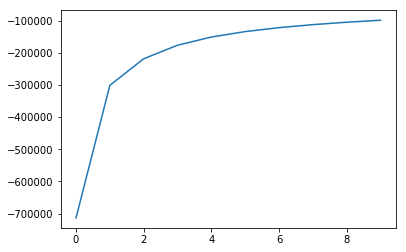

In [76]:
epochs = 1000
epoch_rate = 100
learning_rate = 10e-7
costs = []
for epoch in range(epochs):
    output, hidden = forward(X, W1, b1, W2, b2)
    if epoch % epoch_rate == 0:
        c = cost(T, output)
        P = np.argmax(output, axis=1)
        r = classification_rate(Y, P)
        print('epoch: {} cost: {}. classification rate: {}\n'.format(epoch, c, r))
        costs.append(c)
        
    W2 += learning_rate * derivative_W2(hidden, T, output)
    b2 += learning_rate * derivative_b2(T, output)
    W1 += learning_rate * derivative_W1(X, hidden, T, output, W2)
    b1 += learning_rate * derivative_b1(T, output, W2, hidden)
    
plt.plot(costs)
plt.show();